# Elasto-inertial Turbulence

In this notebook, the Callaham et al. paper's method is used on simulation data of a polymer-laden flow, where the governing equation is much more complex, and some dominant balance regimes may be unknown still, unlike for well-studied cases in the paper (e.g. Turbulent Boundary Layer, Geostrophic Balance,...)

The governing equation is here given by:

$$ \partial_{t}\mathbf{u} + (\mathbf{u} \cdot \mathbf{\nabla})\mathbf{u} + \mathbf{\nabla}p = \frac{\beta}{Re} \Delta \mathbf{u} + \frac{1 - \beta}{Re} \mathbf{\nabla} \cdot \mathbf{T}(\mathbf{C}) $$

where

$ \mathbf{T}(\mathbf{C}) := \frac{1}{Wi}(f(\text{tr}\mathbf{C})\mathbf{C} - \mathbf{I}) $, and $ f(x) := (1 - \frac{x - 3}{L_{max}^{2}})^{-1} $.



Thus, $\mathbf{T}(\mathbf{C}) = \frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1}\mathbf{C} - \mathbf{I}) $



In [58]:
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
from CustomGMM import CustomGMM

## 1. Load the data

In [59]:
# Load the data
path = "../Data/39_60_512_512_CAR.h5"
data = h5py.File(path, "r")

print(data.keys())

<KeysViewHDF5 ['c11', 'c12', 'c22', 'c33', 'p', 'time', 'u', 'v']>


In this dataset are:
- The 4 components of the Conformation Tensor C; $\mathbf{C}_{xx}, \mathbf{C}_{yy}, \mathbf{C}_{zz}, \mathbf{C}_{xy}$.
- The time for which the snapshot corresponds to, t.
- (u, v), the streamwise and wall-normal velocity components
- p, the pressure

They have the following size:
[Seed/Trajectory number, Snapshot number, Nx, Ny], except for time which is just [Seed/Trajectory number, Snapshot number]

There is a few dimensionless parameters that must be set, and these have values set for the data simulation (for CAR statistically steady state):

- $Re = 1000$, the Reynolds number
- $Wi = 50$, the Weissenberg number
- $beta = 0.9$, denotes the viscosity ratio of solvent/polymer contributions to the total kinematic viscosity
- $L_{max} = 70$, the maximum extensibility of the polymer chains
- $[L_{x}, L_{y}] = [2, 2 \pi]$, the domain extents, in units of h (the half-distance between the plates)


In [60]:
# Set some constants
Re = 1000
Wi = 50
beta = 0.9
Lmax = 70
Lx = 2 * np.pi
Ly = 2

## 2. Get the equation space representation of the data

First, the x-component of the governing equation is studied. This is given as:

$$ \partial_{t}u + u u_{x} + v u_{y} + p_{x} = \frac{\beta}{Re} (u_{xx} + u_{yy}) + \frac{1 - \beta}{Re} ( (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xx} - 1))_{x} + (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xy}))_{y} ) $$




Thus the variables needed are:
- $u, \partial u/\partial x, \partial^{2} u/ \partial x^{2}, \partial u/\partial y, \partial^{2} u/ \partial y^{2}, \partial p/\partial x$, and the x-derivative and y-derivative of those last two RHS terms

In [61]:
traj_seed = 5
snapshot = 15

In [62]:
u = data["u"][traj_seed, snapshot - 1 : snapshot + 2, :, :]
v = data["v"][traj_seed, snapshot, :, :]
p = data["p"][traj_seed, snapshot, :, :]
Cxx = data["c11"][traj_seed, snapshot, :, :]
Cxy = data["c12"][traj_seed, snapshot, :, :]
Cyy = data["c22"][traj_seed, snapshot, :, :]
t1 = data["time"][traj_seed, snapshot - 1]
t2 = data["time"][traj_seed, snapshot]
t3 = data["time"][traj_seed, snapshot + 1]

trC = Cxx + Cyy

In [63]:
t1, t2, t3

(1282.0, 1283.0, 1284.0)

In [64]:
u.shape

(3, 512, 512)

In [65]:
# Get the derivatives

u_t = (u[2] - u[0]) / (t3 - t1)

nx = u.shape[2]
ny = u.shape[1]

u_y, u_x = np.gradient(u[1], Ly / ny, Lx / nx)
p_x = np.gradient(p, Lx / nx, axis=1, edge_order=2)

u_xx = np.gradient(u_x, Lx / nx, axis=1, edge_order=2)
u_yy = np.gradient(u_y, Ly / ny, axis=0, edge_order=2)

$$ \partial_{t}u + u u_{x} + v u_{y} + p_{x} = \frac{\beta}{Re} (u_{xx} + u_{yy}) + \frac{1 - \beta}{Re} ( (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xx} - 1))_{x} + (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xy}))_{y} ) $$

In [66]:
# Define the RHS terms

RHS1 = (beta / Re) * (u_xx + u_yy)
RHS2 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cxx - 1)
RHS3 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cxy)

RHS2 = ((1 - beta) / Re) * np.gradient(RHS2, Lx / nx, axis=1, edge_order=2)
RHS3 = ((1 - beta) / Re) * np.gradient(RHS3, Ly / ny, axis=0, edge_order=2)

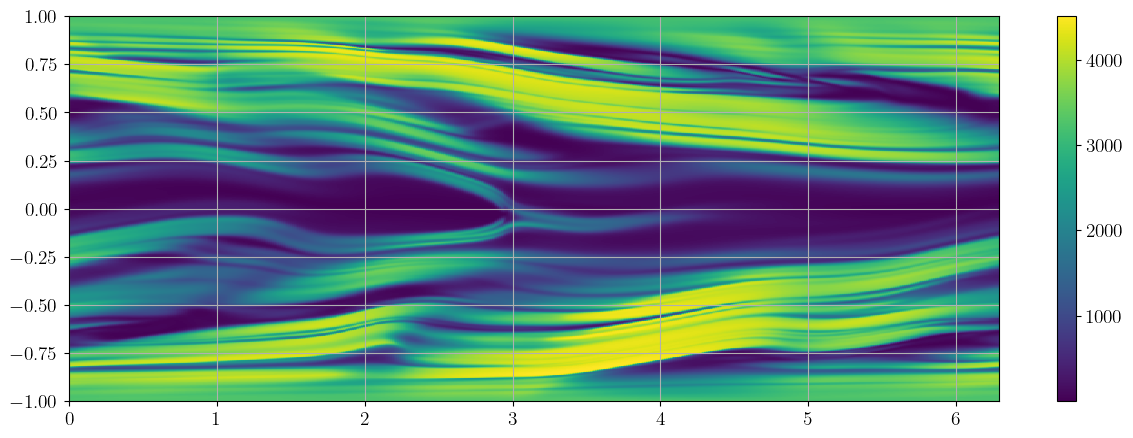

In [67]:
fig = plt.figure(figsize=(15, 5))

X, Y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(-Ly / 2, Ly / 2, ny))


plt.pcolormesh(X, Y, Cxx, cmap="viridis")
plt.colorbar()
plt.grid()

In [68]:
equation = u_t + (u[1] * u_x) + (v * u_y) + p_x - RHS1 - RHS2 - RHS3

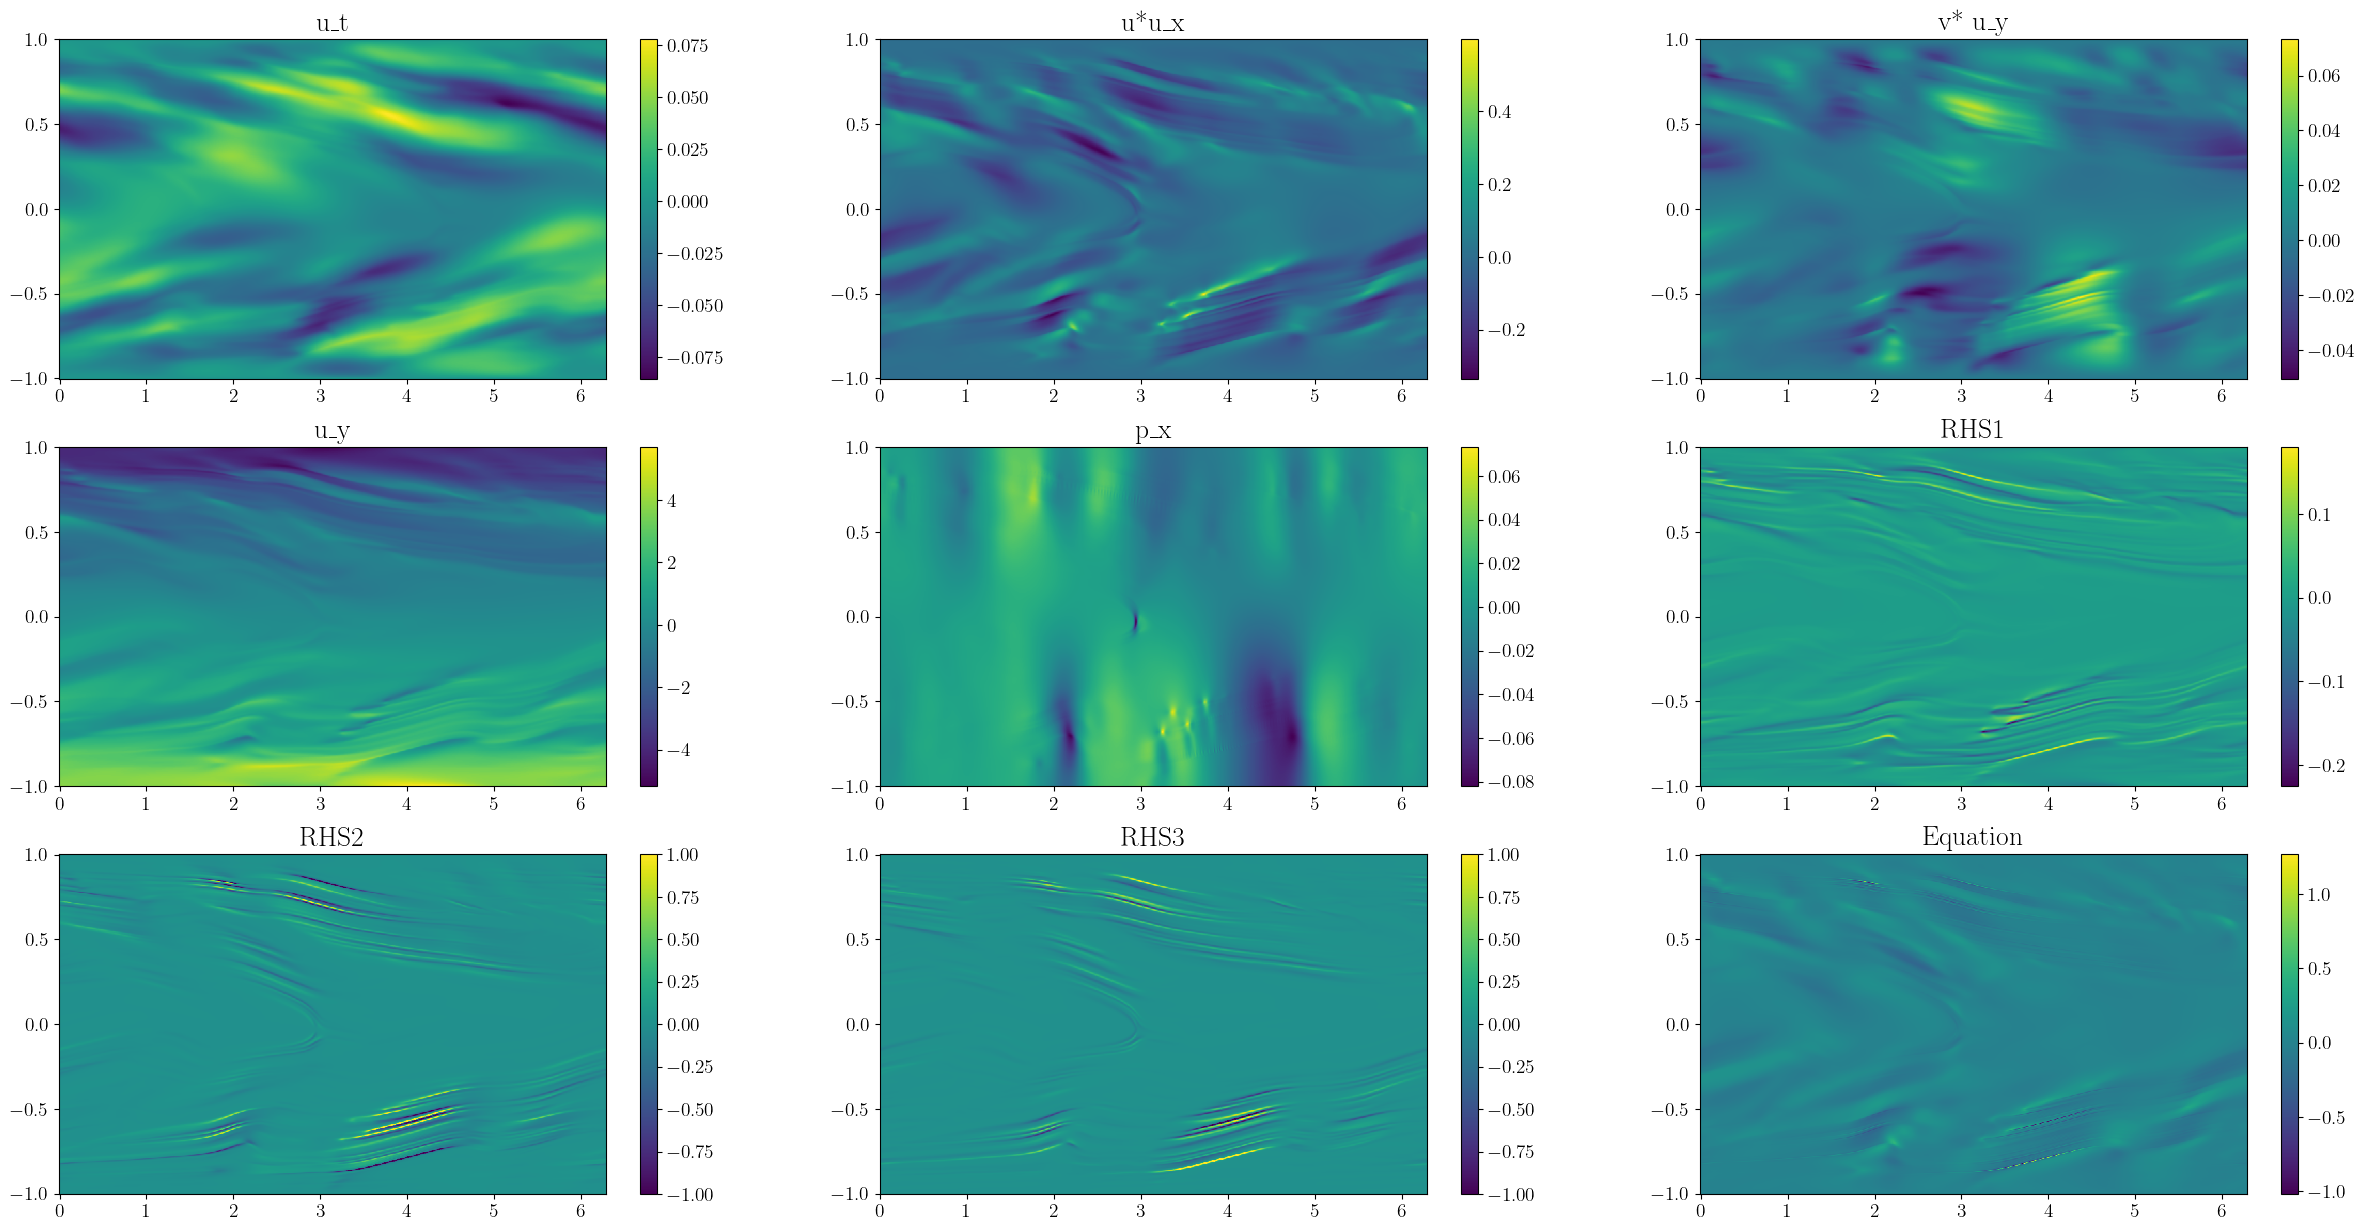

In [69]:
# Plot some scatter plots
fig = plt.subplots(3, 3, figsize=(30, 15))

plt.subplot(3, 3, 1)
plt.pcolormesh(X, Y, u_t, cmap="viridis")
plt.title("u_t")
plt.colorbar()

plt.subplot(3, 3, 2)
plt.pcolormesh(X, Y, u[1] * u_x, cmap="viridis")
plt.title("u*u_x")
plt.colorbar()

plt.subplot(3, 3, 3)
plt.pcolormesh(X, Y, v * u_y, cmap="viridis")
plt.title("v* u_y")
plt.colorbar()

plt.subplot(3, 3, 4)
plt.pcolormesh(X, Y, u_y, cmap="viridis")
plt.title("u_y")
plt.colorbar()


plt.subplot(3, 3, 5)
plt.pcolormesh(X, Y, p_x, cmap="viridis")
plt.title("p_x")
plt.colorbar()

plt.subplot(3, 3, 6)
plt.pcolormesh(X, Y, RHS1, cmap="viridis")
plt.title("RHS1")
plt.colorbar()

plt.subplot(3, 3, 7)
plt.pcolormesh(X, Y, RHS2, cmap="viridis", vmax=1, vmin=-1)
plt.title("RHS2")
plt.colorbar()

plt.subplot(3, 3, 8)
plt.pcolormesh(X, Y, RHS3, cmap="viridis", vmax=1, vmin=-1)
plt.title("RHS3")
plt.colorbar()

plt.subplot(3, 3, 9)
plt.pcolormesh(X, Y, equation, cmap="viridis")
plt.title("Equation")
plt.colorbar()

In [70]:
# Define the features:

features = pd.DataFrame(
    {
        "u_t": u_t.flatten(),
        "uu_x": (u[0] * u_x).flatten(),
        "vu_y": (v * u_y).flatten(),
        "p_x": (p_x).flatten(),
        "nondim_Lap_u": (RHS1).flatten(),
        "tensor1": RHS2.flatten(),
        "tensor2": RHS3.flatten(),
    }
)

features = features.to_numpy()

In [71]:
labels = [
    r"$u_{t}$",
    r"$u u_{x}$",
    r"$v u_{y}$",
    r"$p_{x}$",
    r"$\nabla^2 u$",
    r"${Tensor 1}$",
    r"${Tensor 2}$",
]

In [72]:
print(features.shape)
print(len(features))

(262144, 7)
262144


## 3. Cluster using GMM

In [73]:
# Set the random seeds
seed = 75016
np.random.seed(seed)

# Get a subset of the data
frac = 0.3
features_training = train_test_split(features, train_size=frac, random_state=seed)[0]

# Set number of clusters
n_clusters = 8

# Define the model
GMM = GaussianMixture(n_components=n_clusters, random_state=seed)
# GMM = CustomGMM(n_components=n_clusters, n_features = 7, random_state=seed)

# Fit the model
GMM.fit(features_training)

GaussianMixture(n_components=8, random_state=75016)

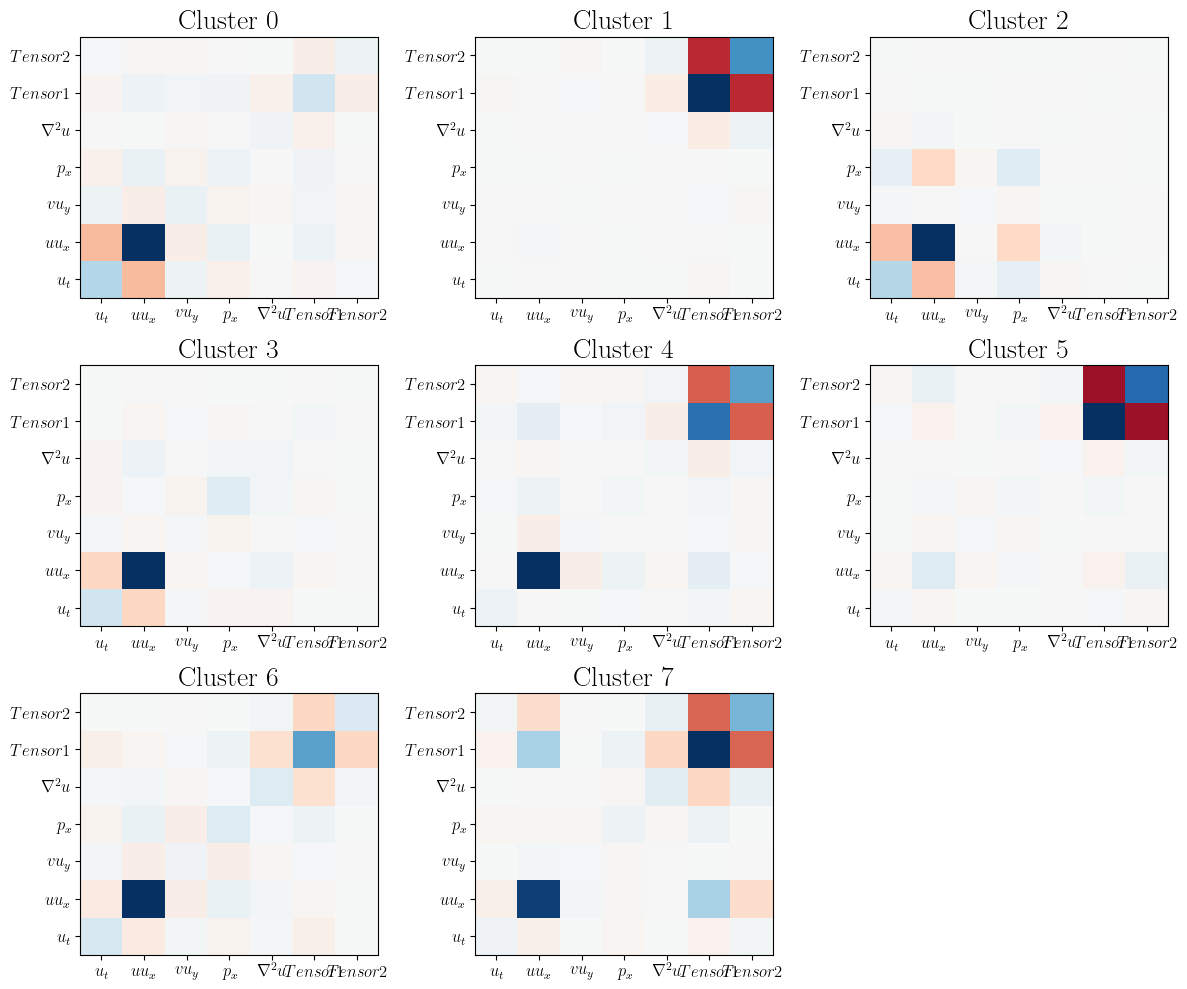

In [74]:
# Plot the covariance matrices of each cluster

pf.plot_cov_mat(GMM, features.shape[1], n_clusters, labels, "GMM")

In [75]:
# Predict the clusters for the entire dataset
cluster_idx = GMM.predict(features)

# FOR UNCERTAINTIES
# Get the cluster membership probabilities
cluster_probs = GMM.predict_proba(features)

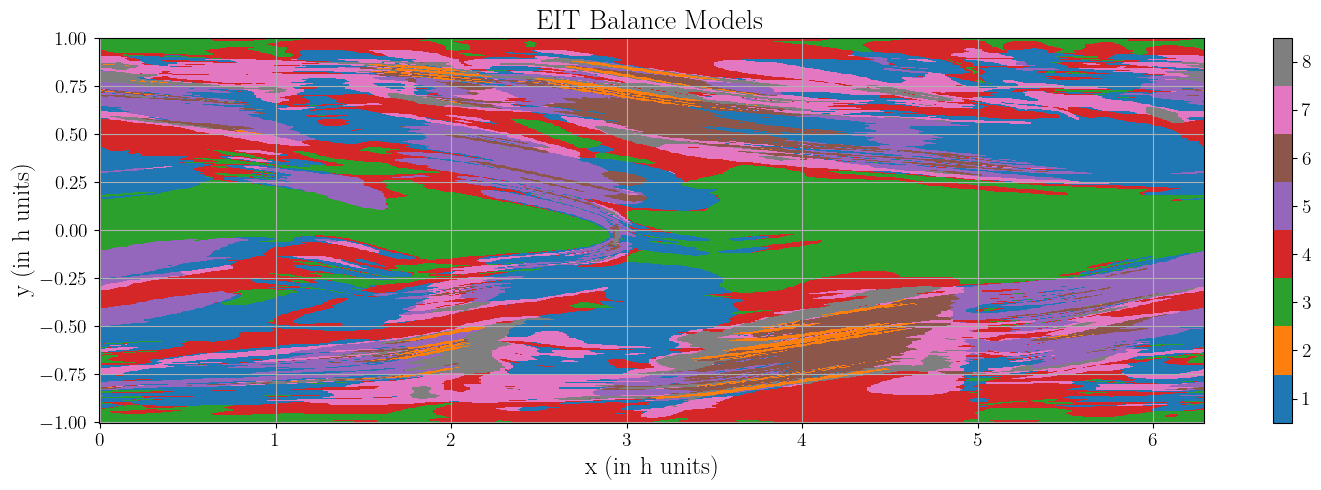

In [76]:
# Plot the clusters in space
clustermap = cluster_idx.reshape((ny, nx))
pf.plot_clusters_eit(clustermap, Lx, nx, Ly, ny, n_clusters)

## 4. SPCA reduction

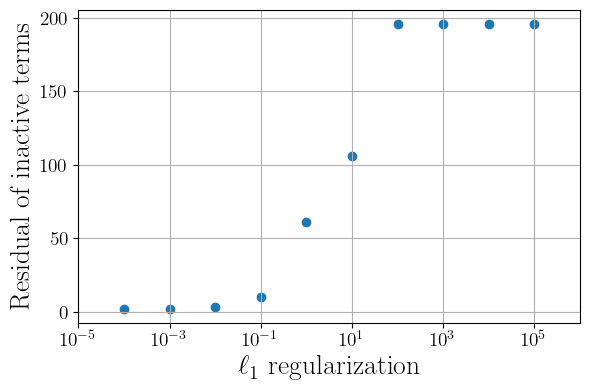

In [77]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err)

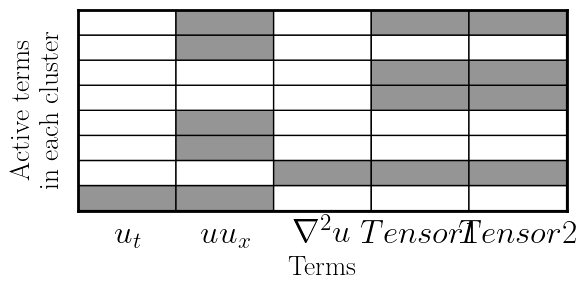

In [78]:
# Set the alpha regularization term to 40
alpha = 3

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, features.shape[1]))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_active_terms(spca_model, labels)

## 5. Get the unique balance models

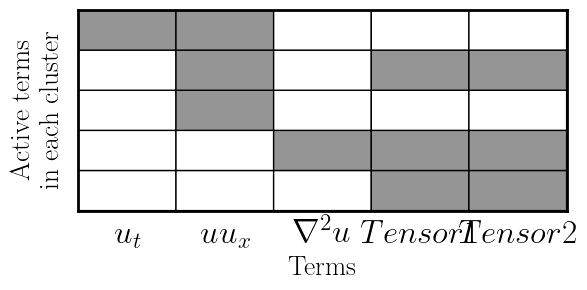

In [79]:
nfeatures = features.shape[1]

# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))
model_idx = np.zeros(len(spca_model), dtype=int)

for i, b_model in enumerate(grouped_models):
    idx = b_model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()

# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]


# Plot a grid of the active terms
pf.plot_active_terms(balance_models, labels)

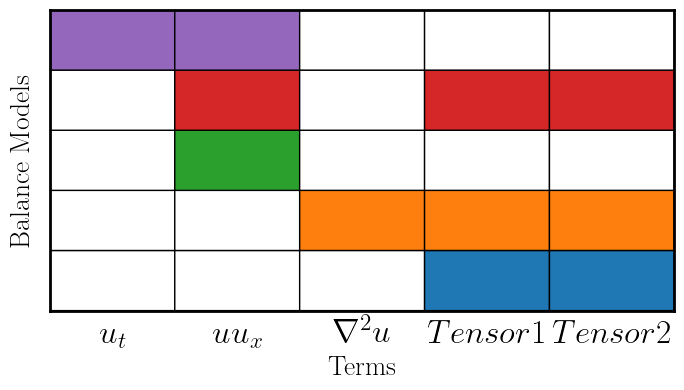

In [80]:
# Plot the balance models in a grid

balance_grid = balance_models.copy()
nmodels = balance_models.shape[0]
gridmask = np.where(balance_grid == 0)


cluster_number = np.arange(nmodels).reshape(nmodels, 1)
balance_grid = balance_grid * cluster_number + 1
balance_grid[gridmask] = 0

# Delete the terms that are inactive in all clusters
grid_mask = np.where(np.all(balance_grid == 0, axis=0))[0]
balance_grid = np.delete(balance_grid, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)


pf.plot_balance_models(balance_grid, grid_labels)

In [81]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

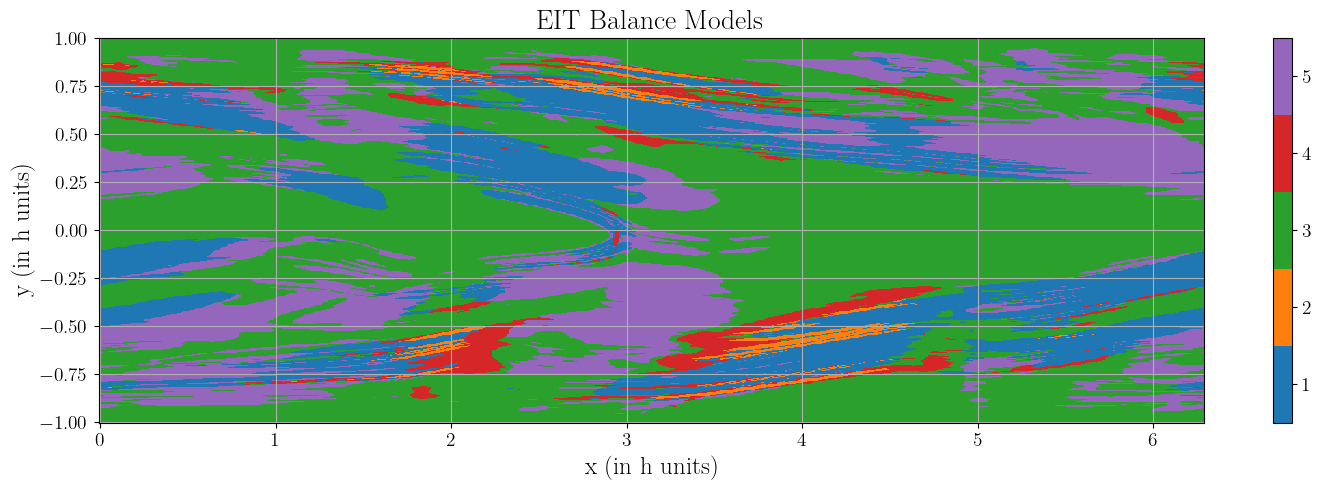

In [82]:
# Plot the clusters in space
balancemap = balance_idx.reshape((ny, nx))
pf.plot_clusters_eit(balancemap, Lx, nx, Ly, ny, nmodels)

## 6. Use GMM's probabilistic nature to get the uncertainty of the results


In the above codes were lines to calculate the uncertainty for each point of belonging in one cluster. For each point, the probability is calculated as the sum of probability of belonging to each cluster that make up the balance model.

In [83]:
print(model_idx)

[4 1 2 2 0 0 2 3]


In [84]:
# FOR UNCERTAINTIES
# Sum the cluster probabilities for the balance model that the point belongs to
# FOR UNCERTAINTIES
balance_probs = np.zeros((len(cluster_idx)))
for i in range(len(cluster_idx)):
    idx = np.where(model_idx == balance_idx[i])[0]
    balance_probs[i] = 1 - np.sum(cluster_probs[i, idx])

In [85]:
print(i)

262143


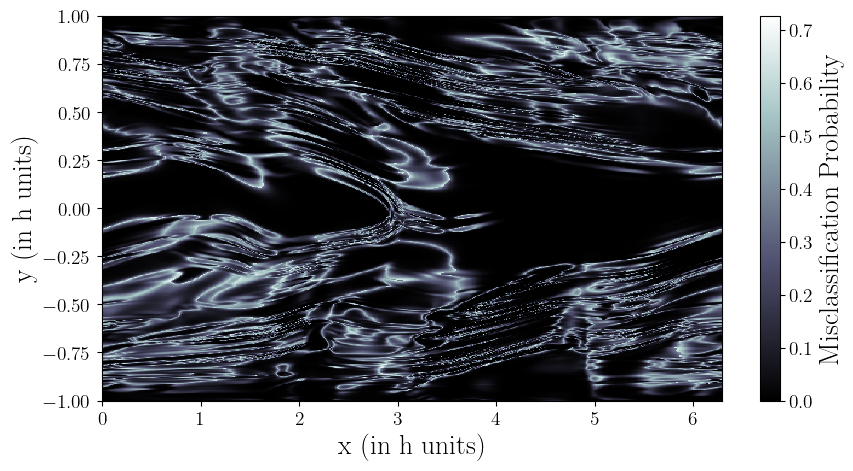

In [86]:
# Plot the balance model probabilities
balance_prob_map = balance_probs.reshape((ny, nx))

plt.figure(figsize=(10, 5))

plt.pcolormesh(X, Y, balance_prob_map, cmap="bone")
plt.xlabel("x (in h units)")
plt.ylabel("y (in h units)")
cbar = plt.colorbar()
cbar.set_label("Misclassification Probability")

## 7. When averaging stream-wise:

In [31]:
# Get the means of the relevant terms
u_t_mean = np.mean(u_t, axis=1)
p_x_mean = np.mean(p_x, axis=1)

In [32]:
RHS1_mean = np.mean(RHS1, axis=1)
RHS2_mean = np.mean(RHS2, axis=1)
RHS3_mean = np.mean(RHS3, axis=1)

In [33]:
LHS1 = u[0] * u_x
LHS2 = v * u_y

LHS1_mean = np.mean(LHS1, axis=1)
LHS2_mean = np.mean(LHS2, axis=1)

In [34]:
u_mean = np.mean(u[0], axis=1)
v_mean = np.mean(v, axis=1)
u_x_mean = np.mean(u_x, axis=1)
u_y_mean = np.mean(u_y, axis=1)
equation_mean = np.mean(equation, axis=1)

u_lines = np.zeros((ny, nx // 2))
v_lines = np.zeros((ny, nx // 2))
u_x_lines = np.zeros((ny, nx // 2))
u_y_lines = np.zeros((ny, nx // 2))
p_x_lines = np.zeros((ny, nx // 2))
RHS1_lines = np.zeros((ny, nx // 2))
RHS2_lines = np.zeros((ny, nx // 2))
RHS3_lines = np.zeros((ny, nx // 2))
equation_lines = np.zeros((ny, nx // 2))


for i in range(ny):
    u_lines[i, :] = u_mean[i]
    v_lines[i, :] = v_mean[i]
    u_x_lines[i, :] = u_x_mean[i]
    u_y_lines[i, :] = u_y_mean[i]
    p_x_lines[i, :] = p_x_mean[i]
    RHS1_lines[i, :] = RHS1_mean[i]
    RHS2_lines[i, :] = RHS2_mean[i]
    RHS3_lines[i, :] = RHS3_mean[i]
    equation_lines[i, :] = equation_mean[i]

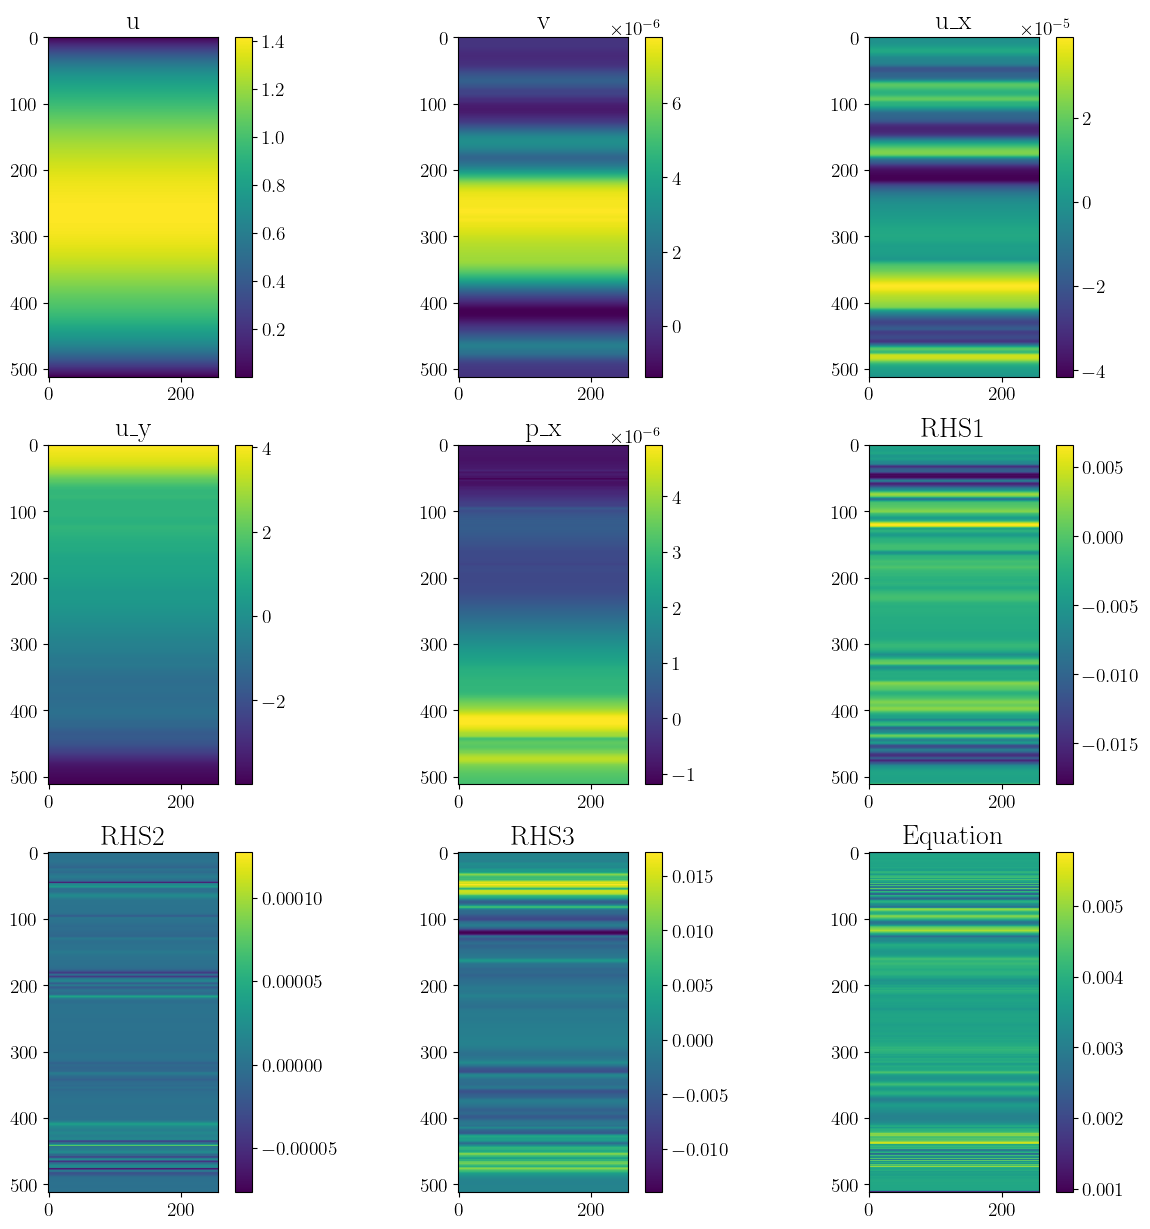

In [35]:
# Plot some scatter plots
fig = plt.subplots(3, 3, figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.imshow(u_lines, cmap="viridis")
plt.colorbar()
plt.title("u")

plt.subplot(3, 3, 2)
plt.imshow(v_lines, cmap="viridis")
plt.title("v")
plt.colorbar()

plt.subplot(3, 3, 3)
plt.imshow(u_x_lines, cmap="viridis")
plt.title("u_x")
plt.colorbar()

plt.subplot(3, 3, 4)
plt.imshow(u_y_lines, cmap="viridis")
plt.title("u_y")
plt.colorbar()


plt.subplot(3, 3, 5)
plt.imshow(p_x_lines, cmap="viridis")
plt.title("p_x")
plt.colorbar()

plt.subplot(3, 3, 6)
plt.imshow(RHS1_lines, cmap="viridis")
plt.title("RHS1")
plt.colorbar()

plt.subplot(3, 3, 7)
plt.imshow(RHS2_lines, cmap="viridis")
plt.title("RHS2")
plt.colorbar()

plt.subplot(3, 3, 8)
plt.imshow(RHS3_lines, cmap="viridis")
plt.title("RHS3")
plt.colorbar()

plt.subplot(3, 3, 9)
plt.imshow(equation_lines, cmap="viridis")
plt.title("Equation")
plt.colorbar()

In [36]:
# Define the features:

features = pd.DataFrame(
    {
        "u_t": u_t_mean.flatten(),
        "uu_x": LHS1_mean.flatten(),
        "vu_y": LHS2_mean.flatten(),
        "p_x": p_x_mean.flatten(),
        "nondim_Lap_u": (RHS1_mean).flatten(),
        "tensor1": RHS2_mean.flatten(),
        "tensor2": RHS3_mean.flatten(),
    }
)

features = features.to_numpy()

In [37]:
# Set the random seeds
seed = 75016
np.random.seed(seed)

In [38]:
# Set number of clusters
n_clusters = 8

# Define the model
GMM = GaussianMixture(n_components=n_clusters, random_state=seed)

# Fit the model
GMM.fit(features)

GaussianMixture(n_components=8, random_state=75016)

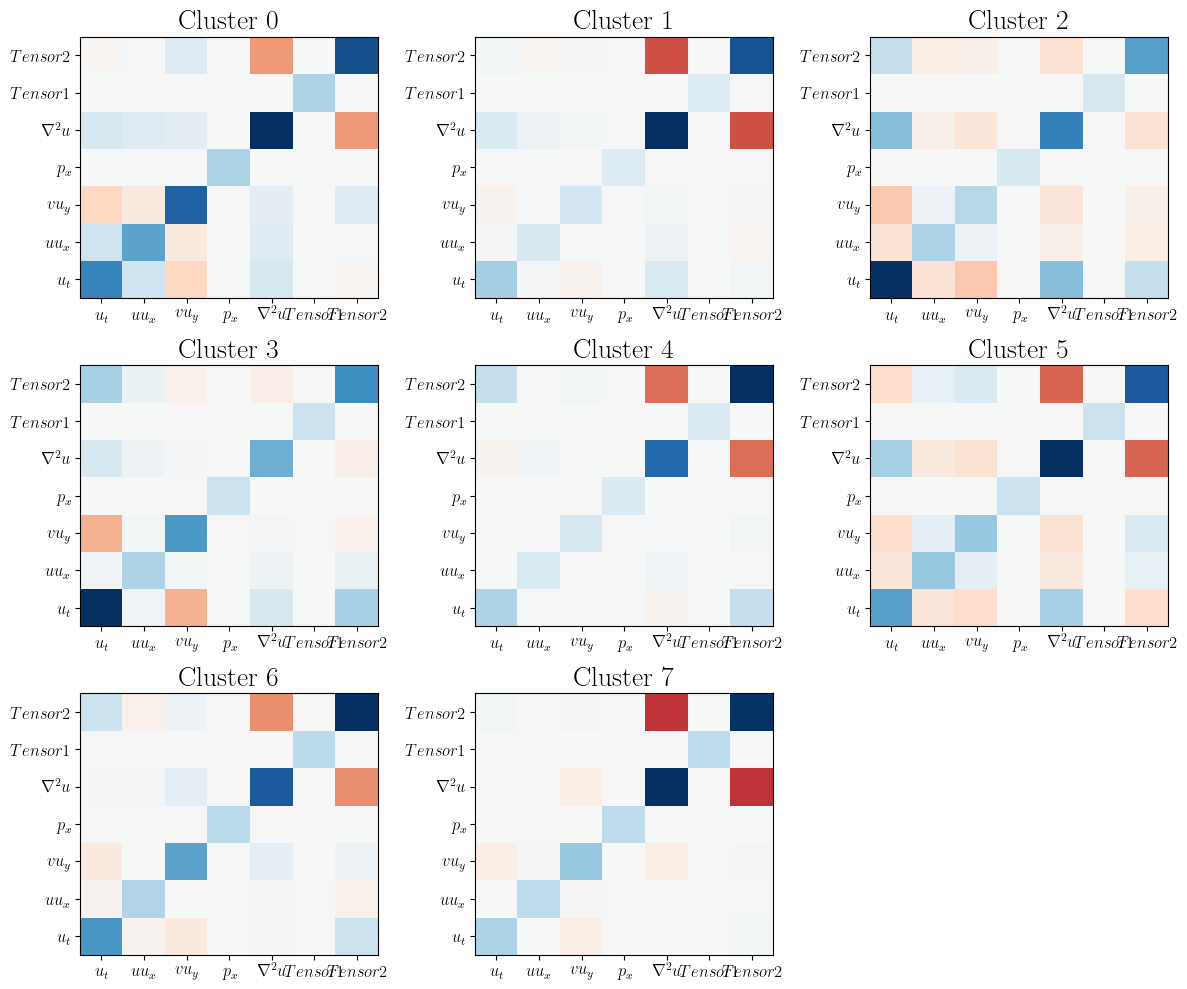

In [39]:
# Plot the covariance matrices of each cluster

pf.plot_cov_mat(GMM, features.shape[1], n_clusters, labels, "GMM")

In [40]:
# Predict the clusters for the entire dataset
cluster_idx = GMM.predict(features)

In [41]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

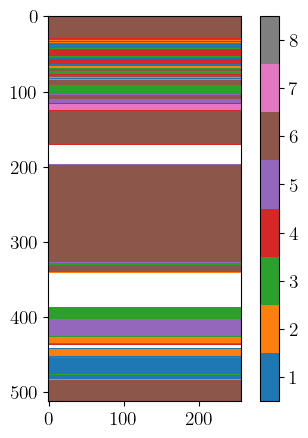

In [42]:
# Plot the clusters in space

fig = plt.figure(figsize=(5, 5))

y = np.linspace(-Ly / 2, Ly / 2, ny)
x = np.zeros_like(y)

cluster_lines = np.zeros((ny, nx // 2))

for i in range(ny):
    cluster_lines[i, :] = cluster_idx[i]


plt.imshow(cluster_lines, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5)
plt.colorbar(
    boundaries=np.arange(0.5, n_clusters + 1.5), ticks=np.arange(0, n_clusters + 1)
)

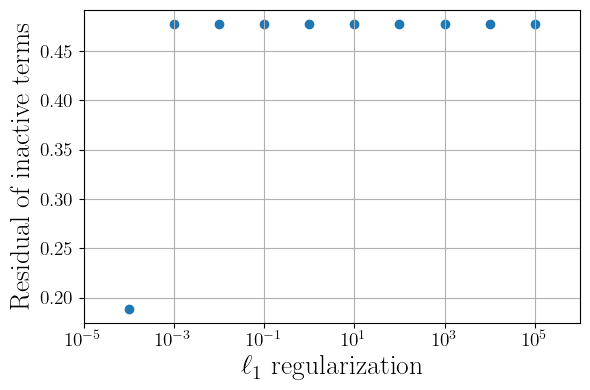

In [43]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err)

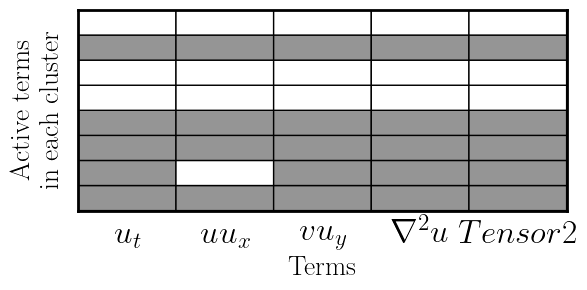

In [53]:
# Set the alpha regularization term to 40
alpha = 1e-4

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, features.shape[1]))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_active_terms(spca_model, labels)

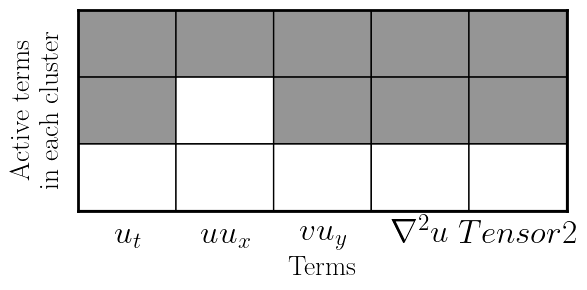

In [54]:
nfeatures = features.shape[1]

# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))
model_idx = np.zeros(len(spca_model), dtype=int)
for i, model in enumerate(grouped_models):
    idx = model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()


# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]


# Plot a grid of the active terms
pf.plot_active_terms(balance_models, labels)

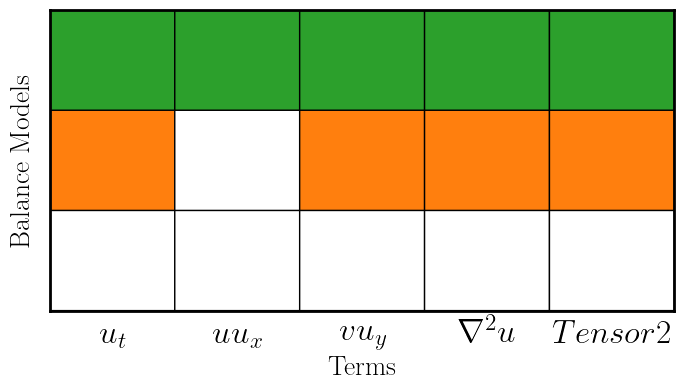

In [55]:
# Plot the balance models in a grid

balance_grid = balance_models.copy()
nmodels = balance_models.shape[0]
gridmask = np.where(balance_grid == 0)


cluster_number = np.arange(nmodels).reshape(nmodels, 1)
balance_grid = balance_grid * cluster_number + 1
balance_grid[gridmask] = 0

# Delete the terms that are inactive in all clusters
grid_mask = np.where(np.all(balance_grid == 0, axis=0))[0]
balance_grid = np.delete(balance_grid, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)


pf.plot_balance_models(balance_grid, grid_labels)

In [56]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

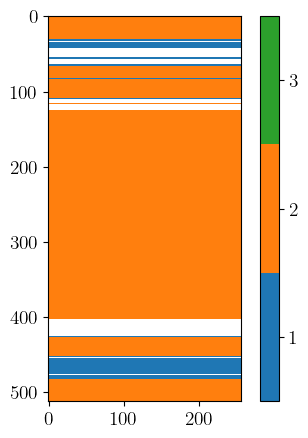

In [57]:
# Plot the clusters in space

fig = plt.figure(figsize=(5, 5))

y = np.linspace(-Ly / 2, Ly / 2, ny)
x = np.zeros_like(y)

balance_lines = np.zeros((ny, nx // 2))

for i in range(ny):
    balance_lines[i, :] = balance_idx[i]


plt.imshow(balance_lines, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5)
plt.colorbar(boundaries=np.arange(0.5, nmodels + 1.5), ticks=np.arange(0, nmodels + 1))